# Визуализация мешей на фоне TRT postscript сечений

Используем меши с максимальным nps на 2025-11-26, nps ~ 1.4e10

In [1]:
import os
import sys

print(sys.version, "at", sys.prefix)

3.13.9 (main, Oct 14 2025, 21:29:44) [Clang 20.1.4 ] at /home/dvp/dev/mckit-meshes/.venv


In [2]:
from enum import IntEnum

In [3]:
from pathlib import Path

import numpy as np

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps as cm
from matplotlib import ticker

In [5]:
%matplotlib inline

See matplotlib [styles](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

In [6]:
# plt.style.available

In [7]:
DEBUG_PLOT = True

class PlotTarget(IntEnum):
    paper = 0,
    presentation = 1,
    jupyter = 2
    

PLOT_TARGET: PlotTarget = PlotTarget.paper



In [8]:
# mpl.use("Qt5agg")
font = {
    "weight": "normal",
    "size": 12,
}
plt.rc("font", **font)
plt.rcParams["mathtext.default"] = "regular"
PUBLICATION_DPI = 1200 #300  # default resolution for publications images
A4_WIDTH = 21  # cm
A4_HEIGHT = 29.7
A4_WIDTH_WITHOUT_MARGIN = A4_WIDTH - 4
INCH = 2.54  # cm
FIG_WIDTH = 16 / INCH
FIG_HEIGHT = FIG_WIDTH / 1.33
# FIG_WIDTH = int(
#     10.6 / INCH
# )  # Optimal for full page witdh graphs, for 1 column graph in 2 column publications use 8cm.
# FIG_HEIGHT = FIG_WIDTH
plt.rcParams["figure.figsize"] = (FIG_WIDTH, FIG_HEIGHT)
# plt.style.use("petroff10")
# plt.rc("grid", color="gray", linestyle="solid")
# plt.rc("xtick", direction="out", color="gray")
# plt.rc("ytick", direction="out", color="gray")
plt.style.use(
    [
        "fivethirtyeight"
    ]
)
background = '#f0f0f0' # - default for fivethirtyeight style
# this will plot gray background in Jupyter
# on saving img to png file the background is transparent

my_params = {
    'figure.dpi': int(os.getenv("JUPYTER_DPI", 88)),  # 88 - optimal for ViewSonic 32" screen, WYSWYG for 16 cm figure width
    "mathtext.default": "regular",
    "figure.figsize": (FIG_WIDTH, FIG_HEIGHT),
    'axes.edgecolor': background,
    'axes.facecolor': background,
    "figure.facecolor": background,
    "savefig.dpi": PUBLICATION_DPI,
    "savefig.transparent": True,
    "savefig.bbox": "tight",
}
plt.rcParams.update(my_params)

markers = "sov^*d"
linestyles = ["-", "--", ":", "-."]

In [9]:
from mckit_meshes.plot import load_plotm_file, Page, plot_ps_page, BriefTicksAroundOneTicker, plot_2d_distribution

In [10]:
from mckit_meshes.fmesh import FMesh

In [11]:
TRT_ROOT = Path("~/dev/mcnp/trt").expanduser()
assert TRT_ROOT.is_dir()

In [12]:
PROTOTYPE_DIR = TRT_ROOT / "mcnp-5/prototype"
assert PROTOTYPE_DIR.is_dir()

In [14]:
PLOTM_DIR = PROTOTYPE_DIR / "plotm"
assert PLOTM_DIR.is_dir()

In [15]:
ps_files = list(PLOTM_DIR.glob("*.ps"))
assert ps_files
ps_files

[PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/plotm-with-normal-bases.ps'),
 PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/plotm.ps'),
 PosixPath('/home/dvp/dev/mcnp/trt/mcnp-5/prototype/plotm/plotm-1.ps')]

In [16]:
pages = { p.stem: load_plotm_file(p)[0] for p in ps_files }
len(pages)

3

In [17]:
!ls {PROTOTYPE_DIR}/results/heat-3/npz/heat-3-1.4e10

 1014.npz   1084.npz   1154.npz   1264.npz   mckit-meshes.log
 1024.npz   1094.npz   1164.npz   1274.npz  'neutron-dose-pz=50.png'
 1034.npz   1104.npz   1214.npz   1284.npz  'total-neutron-flux-pz=50.png'
 1044.npz   1114.npz   1224.npz   1294.npz  'total-photon-flux-pz=50.png'
 1054.npz   1124.npz   1234.npz   1304.npz   vtk
 1064.npz   1134.npz   1244.npz   1314.npz
 1074.npz   1144.npz   1254.npz   1324.npz


## Survey tallies

- 1214 - n flux 
- 1224 - n actual heating, W/cm3
- 1234 - n steel heating, W/cm3
- 1284 - n dose, uSv/h
- 1294 - p dose, uSv/h
- 1304 - p flux
- 1314 - p actual heating, W/cm3
- 1324 - p steel heating, W/cm3


## neutron total flux

In [18]:
NPZ_DIR = PROTOTYPE_DIR / "results/heat-3/npz/heat-3-1.4e10"
assert NPZ_DIR.is_dir()

In [19]:
neutron_flux_mesh = FMesh.load_npz(NPZ_DIR / "1214.npz")

In [20]:
neutron_flux_mesh.totals.shape

(100, 100, 70)

In [21]:
eq_mid_height_idx = neutron_flux_mesh.kbins.searchsorted(50)
0.5*(neutron_flux_mesh.kbins[eq_mid_height_idx-1] + neutron_flux_mesh.kbins[eq_mid_height_idx])

np.float64(49.24)

In [22]:
data = neutron_flux_mesh.totals[:,:, eq_mid_height_idx - 1]
data.shape

(100, 100)

In [42]:
print(f"{data.max():.3g}")

1.25e+12


In [23]:
x, y = neutron_flux_mesh.ibins, neutron_flux_mesh.jbins
X, Y = np.meshgrid(x, y)

In [24]:
def mids(x):
    return 0.5*(x[1:] + x[:-1])

In [25]:
# set(cm.keys())

In [26]:
def plot_2d_distribution(x, y, data, fig, ax,
    *,
    color_bar_title=r"$\frac{1} {cm^{2} \cdot s}$",
    max_log_power=None,
    min_max_log_ratio=1e-4,
    transform=None,
    levels=None,
):
    if max_log_power is None:
        max_log_power = int(np.log10(data.max()))
    vmax = 10.0**max_log_power
    vmin = data.min()
    min_log_power = int(np.log10(vmin)) + 1
    vmin = max(min_max_log_ratio * vmax, 10.0**min_log_power)
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap("hot")
    pcm = ax.pcolormesh(
        x,
        y,
        data,
        norm=norm,
        cmap=cmap,
        # antialiased=True,
        # shading="gouraud",
        shading="flat",
        # transform=transform,
    )
    color_bar = fig.colorbar(pcm, ax=ax, shrink=0.8)
    color_bar.ax.set_title(color_bar_title, pad=20, fontsize=12)
    tick_formatter = BriefTicksAroundOneTicker()
    color_bar.ax.yaxis.set_major_formatter(tick_formatter)
    color_bar.outline.set_edgecolor("white")
    if levels is not None:
        _colors= "k" # cm.get("Wistia_r")(norm(np.array(levels)))
        contours = ax.contour(
            mids(x),
            mids(y),
            data,
            norm=norm,
            levels=levels,
            colors=_colors,
            linewidths=1.0,
            # alpha=0.5,
        )
        levels = contours.levels
        contour_labeled_levels = levels
        fmt = ticker.LogFormatterMathtext()
        fmt.create_dummy_axis()
        ax.clabel(
            contours,
            contour_labeled_levels,
            inline=1.0,
            # fmt="%.1g",
            fmt=fmt,
            # colors="k",
            fontsize=9,
        )
    


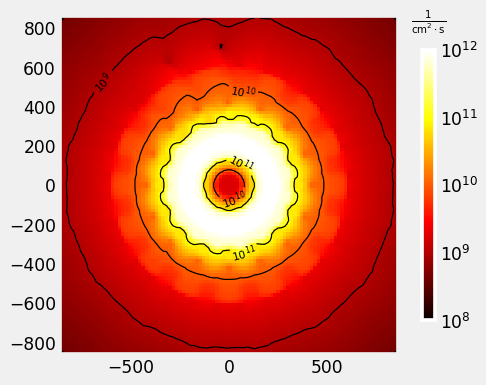

In [39]:
# p = pages["pz=50"]
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
# plot_ps_page(axes, p)
plot_2d_distribution(x, y, data, fig, axes, levels = np.pow(10, np.array([8,9,10,11])))
plt.savefig((NPZ_DIR / "total-neutron-flux-pz=50").with_suffix(".png"), dpi=PUBLICATION_DPI, bbox_inches="tight", transparent=True, metadata={"Title": "Total neutron flux at PZ=50"})
plt.show()

In [43]:
photon_flux_mesh = FMesh.load_npz(NPZ_DIR / "1304.npz")

In [44]:
photon_data = photon_flux_mesh.totals[:,:, eq_mid_height_idx - 1]

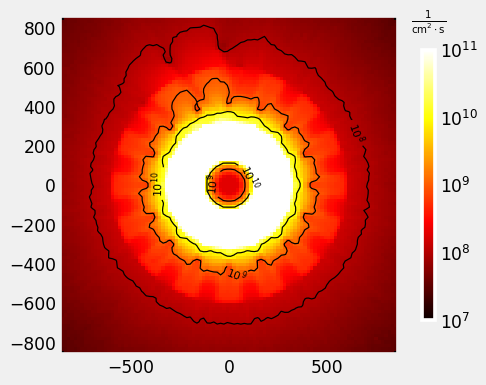

In [45]:
# p = pages["pz=50"]
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
# plot_ps_page(axes, p)
plot_2d_distribution(x, y, photon_data, fig, axes, levels = np.pow(10, np.array([7, 8, 9, 10])))
plt.savefig((NPZ_DIR / "total-photon-flux-pz=50").with_suffix(".png"), dpi=PUBLICATION_DPI, bbox_inches="tight", transparent=True, metadata={"Title": "Total photon flux at PZ=50"})
plt.show()

In [46]:
neutron_dose_mesh = FMesh.load_npz(NPZ_DIR / "1284.npz")

In [47]:
neutron_dose_mesh.data.shape

(1, 100, 100, 70)

In [48]:
neutron_dose_data = neutron_dose_mesh.data[0,:, :, eq_mid_height_idx - 1]

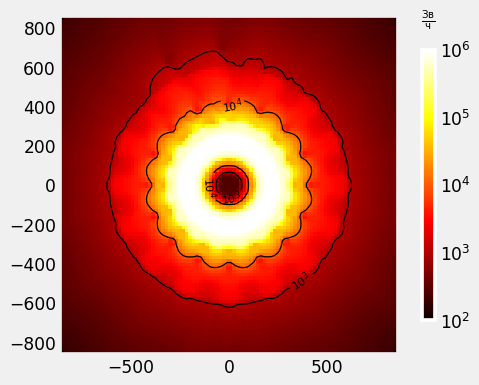

In [49]:
# p = pages["pz=50"]
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
# plot_ps_page(axes, p)
plot_2d_distribution(x, y, neutron_dose_data/1e6, fig, axes,
    color_bar_title=r"$\frac{Зв} {ч}$",
    levels = np.pow(10, np.array([2, 3, 4]))
)
plt.savefig((NPZ_DIR / "neutron-dose-pz=50").with_suffix(".png"), dpi=PUBLICATION_DPI, bbox_inches="tight", transparent=True, metadata={"Title": "Neutron dose rate at PZ=50"})
plt.show()

Несусветные дозы, на ITER (Mode-0 Radiation Maps) дают макс 0.1 Зв/ч вокруг установки, а тут порядка 100-1000. нужно разобраться с нормировками.
Нормировка в fmesh1284 (heat-3.i), похоже, правильная: $pSv/n/cm^{2}\ -> \ \mu Sv/h \ => \ 10^{17} n/cm^{2}s \cdot 3600 s/h \cdot 10^{-6} uSv/pSv = 3.6e14 \mu Sv/h$

Проверим для сравнения дозу полученную в neutron-4.0 

На домашнем компе ps=50 недосупно, так что без него.

In [30]:
old_dose_path = TRT_ROOT / "results/4.0/heat+neutron-4.0/dose.npz"
assert old_dose_path.is_file()

In [31]:
old_dose_mesh = FMesh.load_npz(old_dose_path)

In [33]:
old_dose_mesh.data.shape

(1, 100, 100, 70)

In [35]:
old_dose_data = old_dose_mesh.data[0,:, :, eq_mid_height_idx - 1]

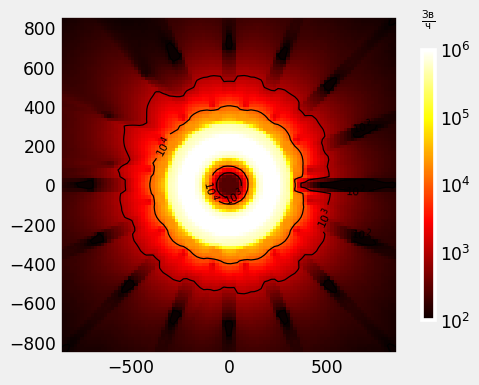

In [38]:
# p = pages["pz=50"]
fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_aspect("equal")
axes.set_xlim(x[0], x[-1])
axes.set_ylim(y[0], y[-1])
# plot_ps_page(axes, p)
plot_2d_distribution(x, y, old_dose_data/1e6, fig, axes,
    color_bar_title=r"$\frac{Зв} {ч}$",
    levels = np.pow(10, np.array([2, 3, 4]))
)
plt.savefig((NPZ_DIR / "old-dose-pz=50").with_suffix(".png"), dpi=PUBLICATION_DPI, bbox_inches="tight", transparent=True, metadata={"Title": "Old dose rate at PZ=50"})
plt.show()

Те же значения. И если прикинуть по функции конверсии (из Recomendations IDM#29PJCT),
to для потока $10^8н/cm^{2}c$ где-то близко значение.
Потоки слишком большие, похоже. А с этим непонятно, что делать. Похоже, что это из-за того, что установка компактная и прозрачная.